# DS12_Assignment

## By Saeideh Pourghasemian

To answer the assignment, use hw_12.csv.

The data set consists of the sales of a product in 200 different markets, along with advertising budgets (in $1,000) for the product in each of those markets for three different media: TV, radio,and newspaper.

The goal of the assignment is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

-- a) Do exploratory analysis to understand your data.

-- b) Split data into test and train. Build a model to predict sales based on TV budget. Assess linear regression assumptions of the model. Baesd on your model, how much increase in sales of the product do you for expect every $1,000 increase in the TV advertising budget?

-- c) Use all features to build a multiple linear regression model. Assess the assumptions of your model.

-- d) Add interaction effect to the model in part b. Does it improve your model? How do you interprete interaction effect in your model?

-- e) Use the best model you have developed to predict sales on test data set. Report MAE and MAPE. Plot actual (y) vs. prediction (y_hat).

In [134]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

In [135]:
data = pd.read_csv('hw_12.csv')

### Function Definition

In [136]:
#Function to plot histogram of residuals
def hist_residuals(model, bins = 50):
    #Calculate density
    from scipy import stats
    density = stats.gaussian_kde(model.resid)
    xp = np.linspace(model.resid.min(), model.resid.max(), 100)
    yp = density.pdf(xp)

    #Histogram
    plt.hist(model.resid, bins = bins, 
             color = 'red', alpha = .4, density = True)
    plt.axvline(model.resid.mean(), color = 'gray', 
                linewidth = 2, linestyle = '--', label = "Average")
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.plot(xp, yp, color = 'gray', linewidth = 2)
    plt.legend()
    
    return plt.show()    

In [137]:
#Function to plot residuals vs. fitted values
def residuals_fittedvalues_plot(model):
    #Implement Lowess algorithm
    lowess_res = sm.nonparametric.lowess(model.resid, model.fittedvalues)

    #Scatter plot: residuals vs. fitted values
    plt.scatter(x = model.fittedvalues, y = model.resid, 
                color = 'red', alpha = .4, label = 'data')
    plt.title('Residuals vs. Fitted values')
    plt.xlabel('Fitted Values', fontsize = 12)
    plt.ylabel('Residuals', fontsize = 12)
    plt.grid()

    #Add LOWESS line
    plt.plot(lowess_res[:, 0], lowess_res[:, 1], 'gray', 
             alpha = .8, linewidth = 2, label = 'LOWESS')
    plt.legend()
    
    #Top three observations with greates absolute value of the residual
    top3 = abs(model.resid).sort_values(ascending = False)[:3]
    for i in top3.index:
        plt.annotate(i, xy = (model.fittedvalues[i], model.resid[i]), color = 'blue')
    
    return plt.show()

In [138]:
#Function to check Cook's distance
def influencer_detector(model, thershold = 1):
    
    #create instance of influence
    influence = model.get_influence()

    #Obtain Cook's distance for each observation
    cooks = influence.cooks_distance

    #Check observations w/ Cook's distance greater than thershold
    return np.where(cooks[0] > 1)

In [139]:
#Function to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    #Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return(vif)

### a)  Data Understanding

In [140]:
data.head()

,no,tv,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [141]:
data.shape

(200, 5)

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   no         200 non-null    int64  
 1   tv         200 non-null    float64
 2   radio      200 non-null    float64
 3   newspaper  200 non-null    float64
 4   sales      200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB



0 no        : number of the market

1 tv        : advertising budgets (in 1,000) for TV (numeric)

2 radio     : advertising budgets (in 1,000) for radio (numeric)

3 newspaper : advertising budgets (in 1,000) for newspaper (numeric)

4 sales     : sales of a product (in 1,000) (numeric)

In [143]:
np.sum(data.isnull())

no           0
tv           0
radio        0
newspaper    0
sales        0
dtype: int64

In [144]:
# Check if all numbers are unique
print(data['no'].nunique())
print(data.shape[0])

200
200


In [145]:
# Chech if there is duplicate rows
np.sum(data.duplicated())

0

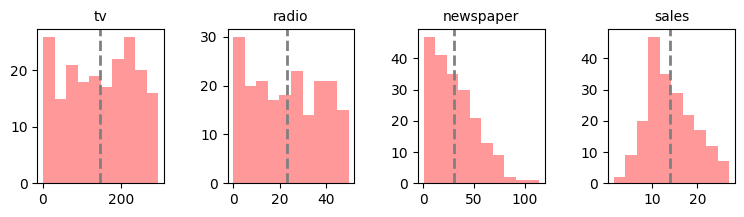

In [146]:
# Histogram of numeric variables
from scipy import stats

var_ind = list(range(1, 5))
plt.figure(figsize = (9, 2))
plt.subplots_adjust(hspace = .5, wspace = .5)

for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.hist(x = data.iloc[: , var_ind[i - 1]], alpha = .4, color = 'red') #density = True
    
    plt.axvline(data.iloc[: , var_ind[i - 1]].mean(), color = 'gray', linewidth = 2, linestyle = '--')
    
    #density = stats.gaussian_kde(data.iloc[: , var_ind[i - 1]])
    #xp = np.linspace(data.iloc[: , var_ind[i - 1]].min(), data.iloc[: , var_ind[i - 1]].max(), 100)
    #yp = density.pdf(xp)
    #plt.plot(xp, yp, color = 'gray', linewidth = 2)
    
    plt.title(data.columns[var_ind[i - 1]], fontsize = 10)


In [147]:
#Summary statistics of numeric variables
data.iloc[:, 1 : 6].describe()

,tv,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


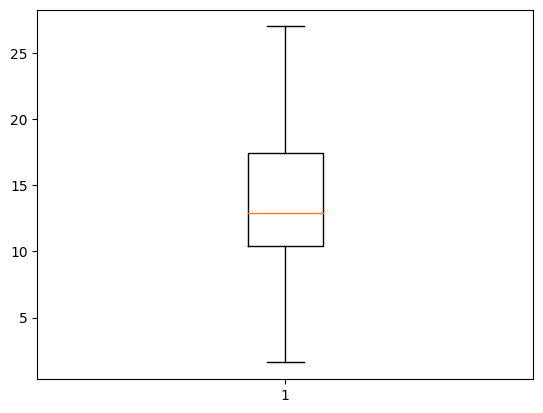

In [148]:
# Check for outliers
plt.boxplot(data['sales'])
plt.show()

In [149]:
#Correlation analysis
round(data.iloc[:, 1:5].corr(method = 'pearson'), 2)

,tv,radio,newspaper,sales
tv,1.00,0.05,0.06,0.78
radio,0.05,1.00,0.35,0.58
newspaper,0.06,0.35,1.00,0.23
sales,0.78,0.58,0.23,1.00


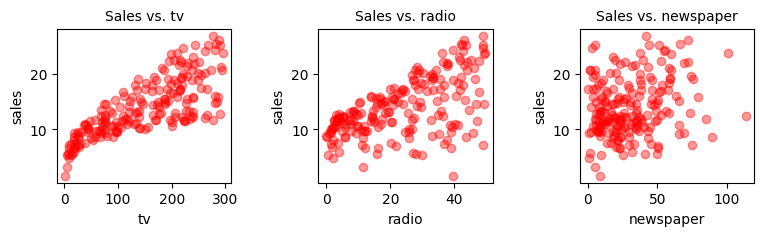

In [150]:
#Scatter plot
var_ind = list(range(1, 4))
plt.figure(figsize = (9, 2))
plt.subplots_adjust(hspace = .5, wspace = .5)

for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.scatter(x = data.iloc[: , var_ind[i - 1]], y = data['sales'], alpha = .4, color = 'red')
    plt.title('Sales vs. ' + data.columns[var_ind[i - 1]], fontsize = 10)
    plt.xlabel(data.columns[var_ind[i - 1]])
    plt.ylabel('sales')

### b)  Building a Linear Regression Model - Sales vs. TV Budget

In [151]:
#Split data into test and train
train, test = train_test_split(data.loc[:, ['tv','sales']], test_size = .2, random_state = 123)
print(train.shape)
print(test.shape)

(160, 2)
(40, 2)


In [152]:
#Define feature matrix 
x_train = train['tv']
x_train = sm.add_constant(x_train) #add constant
x_train.head()

,const,tv
24,1.0,62.3
150,1.0,280.7
114,1.0,78.2
33,1.0,265.6
23,1.0,228.3


In [153]:
#Define response matrix
y_train = train['sales']
y_train.head()

24      9.7
150    16.1
114    14.6
33     17.4
23     15.5
Name: sales, dtype: float64

In [154]:
#Linear regression - mpdel_tv
model_tv = sm.OLS(y_train, x_train).fit()
model_tv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     229.2
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.44e-32
Time:                        05:38:10   Log-Likelihood:                -416.24
No. Observations:                 160   AIC:                             836.5
Df Residuals:                     158   BIC:                             842.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1815      0.525     13.673      0.000       6.144       8.219
tv             0.0459      0.003     15.140      0.000       0.040       0.052
==============================================================================
Omnibus:                        1.234   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.539   Jarque-Bera (JB):                1.130
Skew:                          -0.022   Prob(JB):                        0.568
Kurtosis:                       2.591   Cond. No.                         351.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

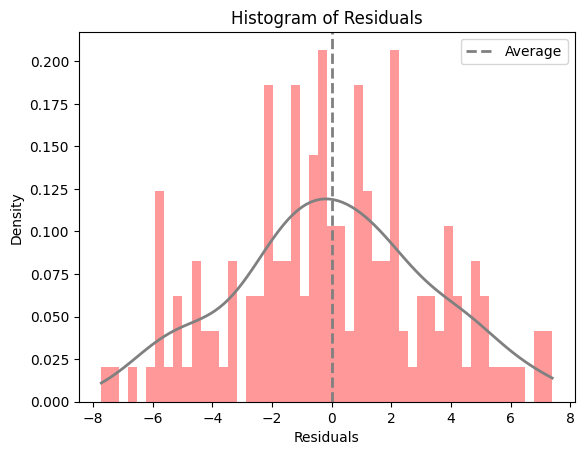

In [155]:
#Histogram of residuals - model_tv
hist_residuals(model_tv)

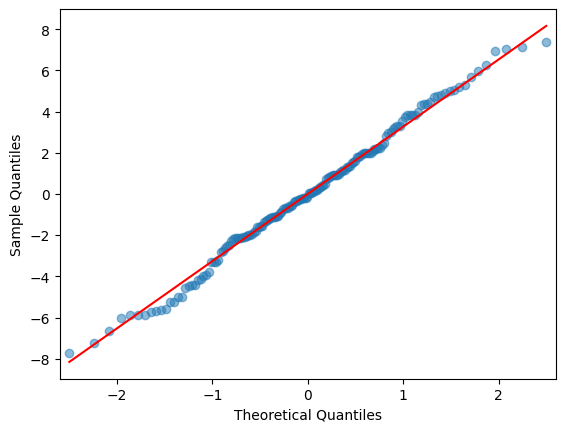

In [156]:
#QQ-plot - model_tv
sm.qqplot(model_tv.resid, line = 's', alpha = .5)
plt.show()

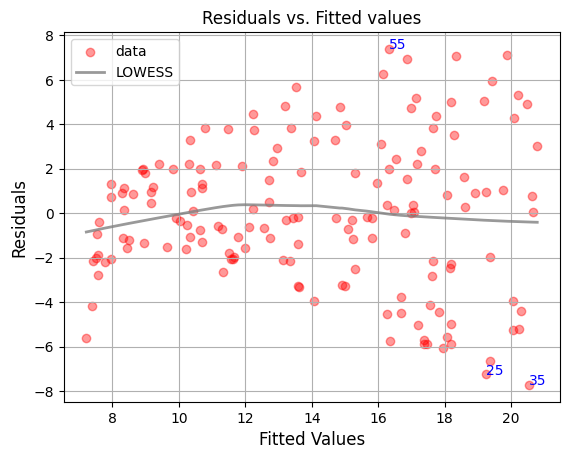

In [157]:
#Scatter plot of residuals vs. fitted values - model_tv
residuals_fittedvalues_plot(model_tv)

In [158]:
print('Increasing the TV advertising budget by $1,000 will result in a sales increase of ${p_sale}.'
     .format(p_sale = round(.047 * 1 + 7.0766, 2))) # model_tv.predict([1,1])

Increasing the TV advertising budget by $1,000 will result in a sales increase of $7.12.


### c)  Building a Multiple Linear Regression Model 

In [159]:
#Split data into test and train
train, test = train_test_split(data.iloc[:, 1:], test_size = .2, random_state = 123)
print(train.shape)
print(test.shape)
train.head()

(160, 4)
(40, 4)


,tv,radio,newspaper,sales
24,62.3,12.6,18.3,9.7
150,280.7,13.9,37.0,16.1
114,78.2,46.8,34.5,14.6
33,265.6,20.0,0.3,17.4
23,228.3,16.9,26.2,15.5


In [160]:
#Define feature matrix 
x_train = train.iloc[:, 0:3]
x_train = sm.add_constant(x_train) #add constant
x_train.head()

,const,tv,radio,newspaper
24,1.0,62.3,12.6,18.3
150,1.0,280.7,13.9,37.0
114,1.0,78.2,46.8,34.5
33,1.0,265.6,20.0,0.3
23,1.0,228.3,16.9,26.2


In [161]:
#Define response matrix
y_train = train['sales']
y_train.head()

24      9.7
150    16.1
114    14.6
33     17.4
23     15.5
Name: sales, dtype: float64

In [162]:
#Linear regression - model_all_1
model_all_1 = sm.OLS(y_train, x_train).fit()
model_all_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     409.8
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           9.89e-74
Time:                        05:38:11   Log-Likelihood:                -313.24
No. Observations:                 160   AIC:                             634.5
Df Residuals:                     156   BIC:                             646.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9242      0.365      8.018      0.000       2.204       3.645
tv             0.0456      0.002     28.437      0.000       0.042       0.049
radio          0.1865      0.010     18.700      0.000       0.167       0.206
newspaper     -0.0006      0.007     -0.094      0.925      -0.014       0.013
==============================================================================
Omnibus:                       50.642   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.512
Skew:                          -1.335   Prob(JB):                     1.51e-27
Kurtosis:                       6.376   Cond. No.                         469.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

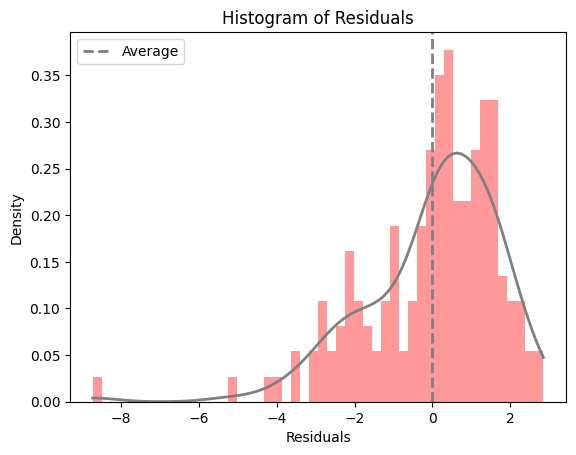

In [163]:
#Histogram of residuals - model_all_1
hist_residuals(model_all_1)

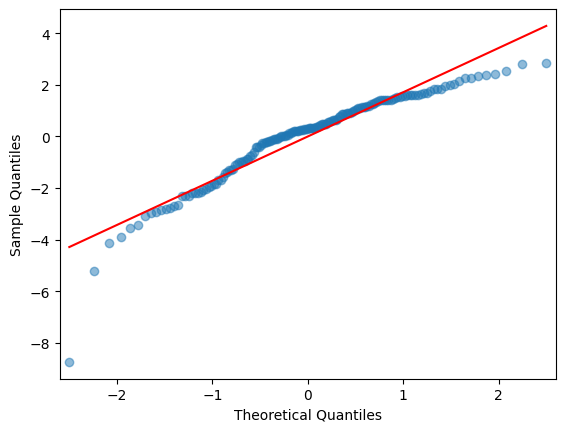

In [164]:
#QQ-plot - model_all_1
sm.qqplot(model_all_1.resid, line = 's', alpha = .5)
plt.show()

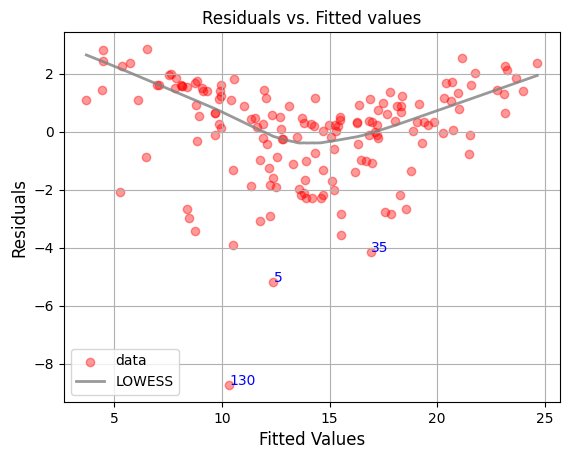

In [165]:
#Scatter plot of residuals vs. fitted values - model_all_1
residuals_fittedvalues_plot(model_all_1)

In [166]:
train.iloc[[130, 5, 35], :]

,tv,radio,newspaper,sales
173,168.4,7.1,12.8,11.7
171,164.5,20.9,47.4,14.5
44,25.1,25.7,43.3,8.5


In [167]:
#Check Cook's ditance - model_all_1
influencer_detector(model_all_1)

(array([], dtype=int64),)

In [168]:
#Check multicollinearity for numeric variables
calc_vif(x_train)
#Note: If VIF > 10 then multicollinearity is high

,variables,VIF
0,const,7.063736
1,tv,1.000721
2,radio,1.175085
3,newspaper,1.175825


In [169]:
#Box-Cox transformation
boxcox = PowerTransformer(method = 'box-cox')
boxcox.fit(y_train.values.reshape(-1, 1))
boxcox.lambdas_

array([0.65457649])

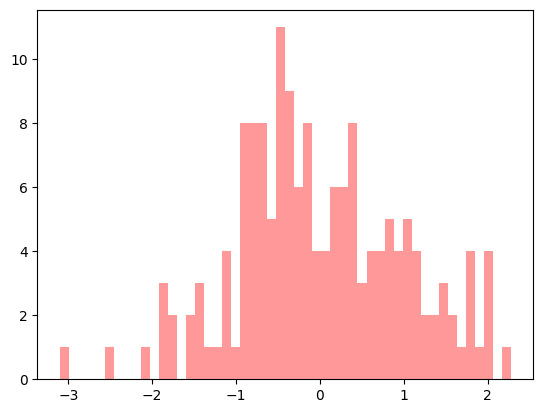

In [170]:
trans_y_train = boxcox.fit_transform(y_train.values.reshape(-1, 1))
plt.hist(trans_y_train, color = 'red', alpha = .4, bins = 50)
plt.show()

In [171]:
#Linear regression - model_all_2
model_all_2 = sm.OLS(trans_y_train, x_train).fit()
model_all_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     360.1
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           7.11e-70
Time:                        05:38:11   Log-Likelihood:                -61.434
No. Observations:                 160   AIC:                             130.9
Df Residuals:                     156   BIC:                             143.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1658      0.076    -28.651      0.000      -2.315      -2.016
tv             0.0090      0.000     27.228      0.000       0.008       0.010
radio          0.0345      0.002     16.701      0.000       0.030       0.039
newspaper   9.485e-05      0.001      0.068      0.946      -0.003       0.003
==============================================================================
Omnibus:                      104.499   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              817.878
Skew:                          -2.312   Prob(JB):                    2.51e-178
Kurtosis:                      13.065   Cond. No.                         469.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

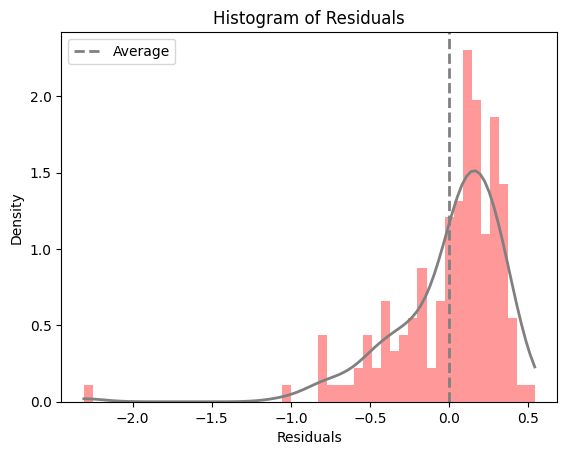

In [172]:
#Histogram of residuals - model_all_2
hist_residuals(model_all_2)

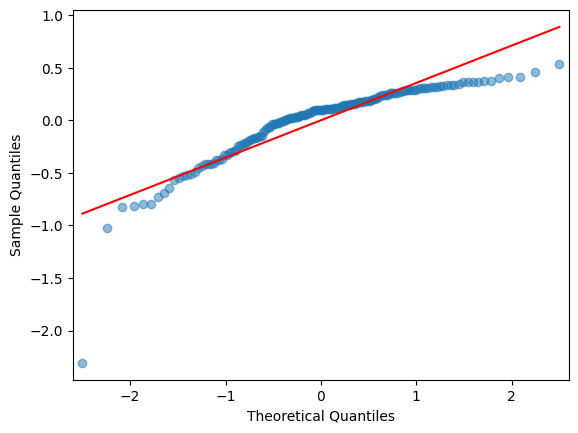

In [173]:
#QQ-plot - model_all_2
sm.qqplot(model_all_2.resid, line = 's', alpha = .5)
plt.show()

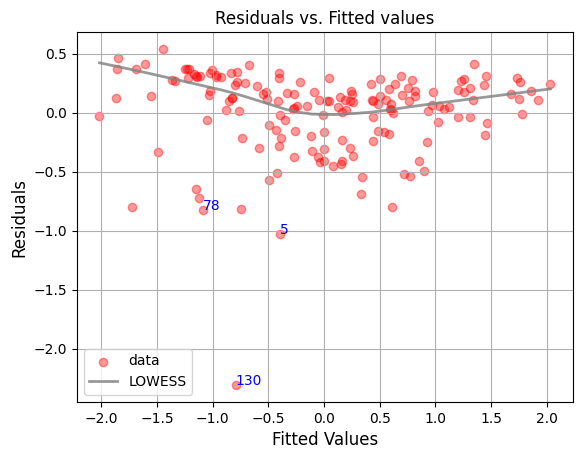

In [174]:
#Scatter plot of residuals vs. fitted values - model_all_2
residuals_fittedvalues_plot(model_all_2)

In [175]:
#Check Cook's ditance - model_all_2
influencer_detector(model_all_2)

(array([], dtype=int64),)

In [176]:
#Remove non-significant variables from regression model
x_train.drop(columns = ['newspaper'], inplace = True)

In [177]:
#Linear regression - model_all_3
model_all_3 = sm.OLS(trans_y_train, x_train).fit()
model_all_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     543.6
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           2.70e-71
Time:                        05:38:12   Log-Likelihood:                -61.436
No. Observations:                 160   AIC:                             128.9
Df Residuals:                     157   BIC:                             138.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1643      0.072    -30.040      0.000      -2.307      -2.022
tv             0.0090      0.000     27.325      0.000       0.008       0.010
radio          0.0346      0.002     18.190      0.000       0.031       0.038
==============================================================================
Omnibus:                      104.763   Durbin-Watson:                   2.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.280
Skew:                          -2.317   Prob(JB):                    6.21e-180
Kurtosis:                      13.116   Cond. No.                         443.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

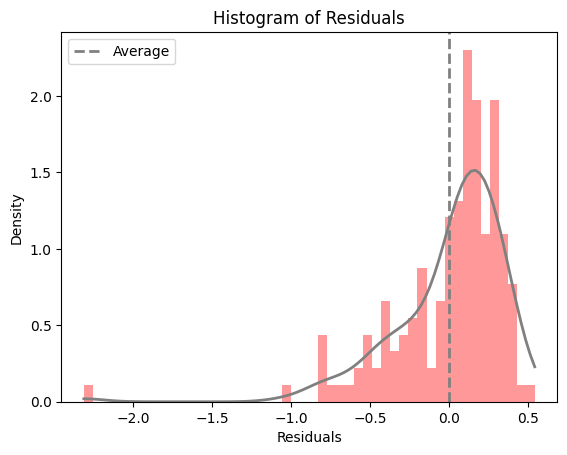

In [178]:
#Histogram of residuals - model_all_3
hist_residuals(model_all_3)

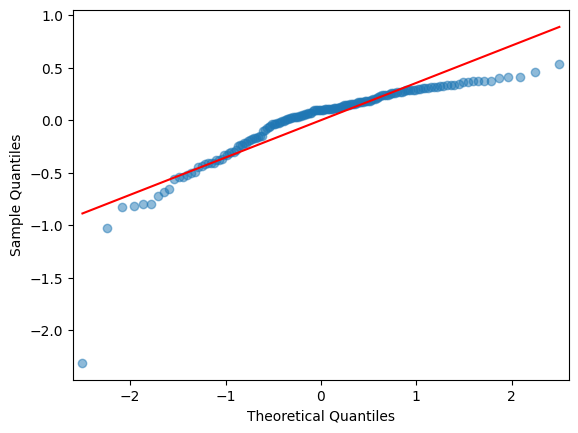

In [179]:
#QQ-plot - model_all_3
sm.qqplot(model_all_3.resid, line = 's', alpha = .5)
plt.show()

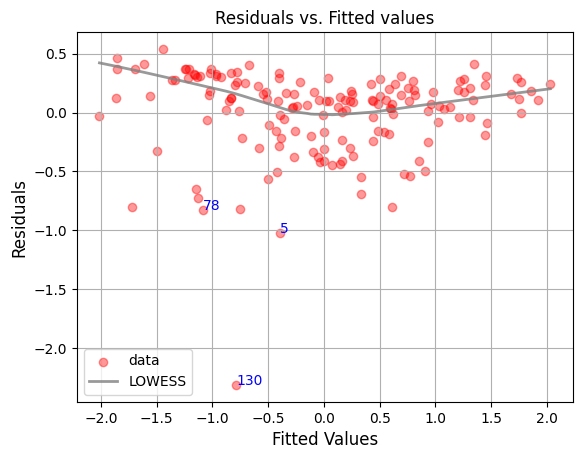

In [180]:
#Scatter plot of residuals vs. fitted values - model_all_3
residuals_fittedvalues_plot(model_all_3)

### d)  Interaction Effect

In [181]:
#Split data into test and train
train, test = train_test_split(data.iloc[:, [1, 2, 4]], test_size = .2, random_state = 123)
train['int_var'] = train['tv']*train['radio']
print(train.shape)
print(test.shape)
train.head()

(160, 4)
(40, 3)


,tv,radio,sales,int_var
24,62.3,12.6,9.7,784.98
150,280.7,13.9,16.1,3901.73
114,78.2,46.8,14.6,3659.76
33,265.6,20.0,17.4,5312.00
23,228.3,16.9,15.5,3858.27


In [182]:
#Define feature matrix
x_train = train.iloc[:, [0, 1, 3]]
x_train = sm.add_constant(x_train) #add constant
x_train.head()

,const,tv,radio,int_var
24,1.0,62.3,12.6,784.98
150,1.0,280.7,13.9,3901.73
114,1.0,78.2,46.8,3659.76
33,1.0,265.6,20.0,5312.00
23,1.0,228.3,16.9,3858.27


In [183]:
#Linear regression - model_int_1 
model_int_1 = sm.OLS(trans_y_train, x_train).fit()
model_int_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     685.9
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.35e-89
Time:                        05:38:13   Log-Likelihood:                -14.824
No. Observations:                 160   AIC:                             37.65
Df Residuals:                     156   BIC:                             49.95
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5030      0.080    -18.699      0.000      -1.662      -1.344
tv             0.0045      0.000      9.459      0.000       0.004       0.005
radio          0.0078      0.003      2.777      0.006       0.002       0.013
int_var        0.0002   1.65e-05     11.107      0.000       0.000       0.000
==============================================================================
Omnibus:                      142.110   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2262.392
Skew:                          -3.176   Prob(JB):                         0.00
Kurtosis:                      20.292   Cond. No.                     1.82e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

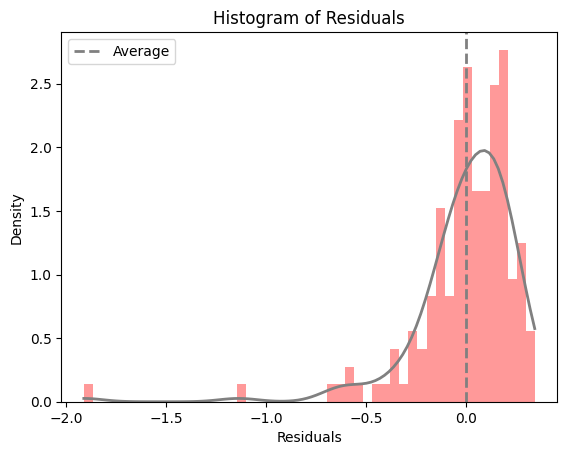

In [184]:
#Histogram of residuals model_int_1
hist_residuals(model_int_1)

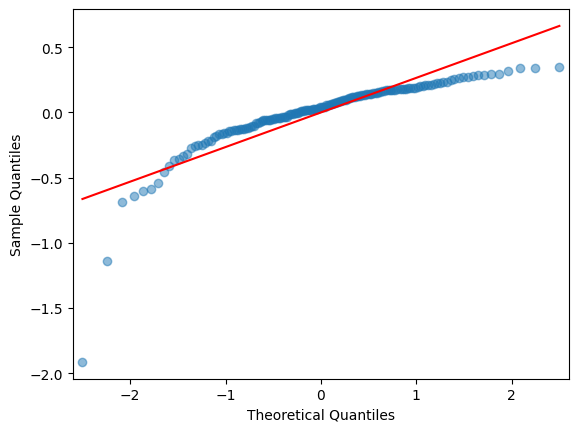

In [185]:
#QQ-plot - model_int_1
sm.qqplot(model_int_1.resid, line = 's', alpha = .5)
plt.show()

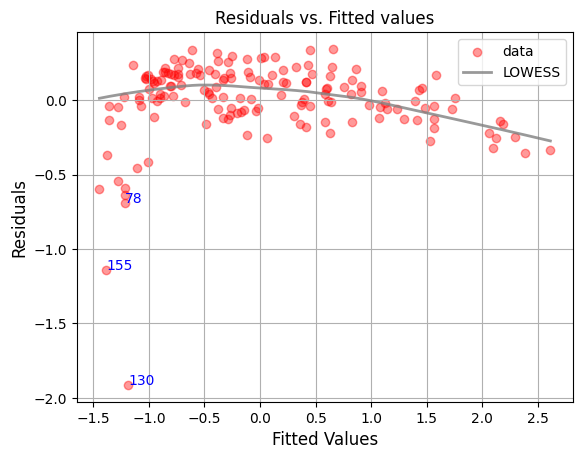

In [186]:
#Scatter plot of residuals vs. fitted values - model_int_1
residuals_fittedvalues_plot(model_int_1)

### e) Test Evaluation 

In [187]:
#Define the test matrix 
test['int_var'] = test['tv']*test['radio']
x_test = test.iloc[:, [0, 1, 3]]
x_test = sm.add_constant(x_test)
y_test = test['sales']

In [188]:
x_test.head()

,const,tv,radio,int_var
50,1.0,199.8,3.1,619.38
127,1.0,80.2,0.0,0.00
37,1.0,74.7,49.4,3690.18
149,1.0,44.7,25.8,1153.26
19,1.0,147.3,23.9,3520.47


In [189]:
y_test.head()

50     11.4
127     8.8
37     14.7
149    10.1
19     14.6
Name: sales, dtype: float64

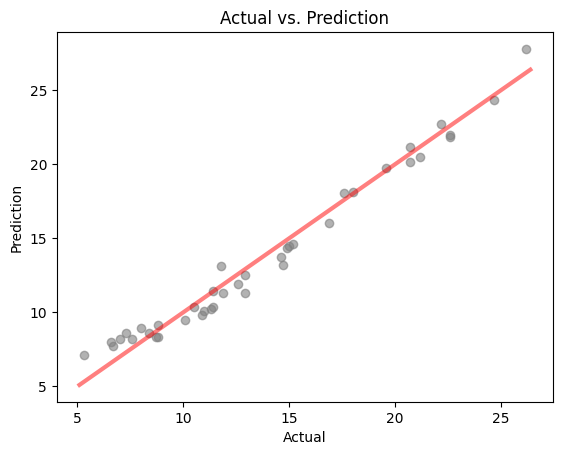

In [190]:
#Plot actual vs. prediction - Test
test_pred = model_int_1.predict(x_test)


#Inverse transformation of predicted values
test['pred_sale'] = pd.Series(boxcox.inverse_transform(test_pred.values.reshape(-1, 1)).reshape(-1), 
                         index = test_pred.index)

plt.scatter(test['sales'], test['pred_sale'], c = 'gray', alpha = .6)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction')
xp = np.linspace(test['sales'].min() - 0.2, test['sales'].max() + 0.2, 100)
plt.plot(xp, xp, c = 'red', linewidth = 3, alpha = .5)
plt.show()

In [191]:
#Absolute error
test['abs_err'] = round(abs(test['sales'] - test['pred_sale']) / test['sales'] , 2)
MAE_test = round(np.mean(test['abs_err']), 2)
MAE_test

0.07

In [192]:
#Absolute percentage error
test['abs_pct_err'] = round(abs(test['sales'] - test['pred_sale']) / test['sales'] * 100, 2)
MAPE_test = round(np.mean(test['abs_pct_err']), 2)
MAPE_test

7.1

In [193]:
#Check obervations with large absolute percentage error
test.sort_values(by = 'abs_pct_err', ascending = False, inplace = True)
test.head()

,tv,radio,sales,int_var,pred_sale,abs_err,abs_pct_err
108,13.1,0.4,5.3,5.24,7.110572,0.34,34.16
119,19.4,16.0,6.6,310.40,7.967128,0.21,20.71
158,11.7,36.9,7.3,431.73,8.612851,0.18,17.98
121,18.8,21.7,7.0,407.96,8.221133,0.17,17.44
189,18.7,12.1,6.7,226.27,7.760414,0.16,15.83


In [194]:
#Marketing Requirement
sum(test['abs_pct_err'] <= 15) / test.shape[0] * 100

87.5